# Comparison CellRank on RNA vs. MultiVelo + CellRank on RNA+ATAC

We will use the embryonic E18 mouse brain from 10X Multiome as an example.

CellRanger output files can be downloaded from [10X website](https://www.10xgenomics.com/resources/datasets/fresh-embryonic-e-18-mouse-brain-5-k-1-standard-1-0-0). Crucially, the filtered feature barcode matrix folder, ATAC peak annotations TSV, and the feature linkage BEDPE file in the secondary analysis outputs folder will be needed in this demo. 

Quantified unspliced and spliced counts from Velocyto can be downloaded from [MultiVelo GitHub page](https://github.com/welch-lab/MultiVelo).

We provide the cell annotations for this dataset in "cell_annotations.tsv" on the GitHub page. (To download from GitHub, click on the file, then click "Raw" on the top right corner. If it opens in your browser, you can download the page as a text file.)

Weighted nearest neighbors from Seurat can be downloaded from GitHub folder "seurat_wnn", which contains a zip file of three files: "nn_cells.txt", "nn_dist.txt", and "nn_idx.txt". Please unzip the archive after downloading. The R script used to generate such files can also be found in the same folder.
```
.
|-- MultiVelo_Demo.ipynb
|-- cell_annotations.tsv
|-- outs
|   |-- analysis
|   |   `-- feature_linkage
|   |       `-- feature_linkage.bedpe
|   |-- filtered_feature_bc_matrix
|   |   |-- barcodes.tsv.gz
|   |   |-- features.tsv.gz
|   |   `-- matrix.mtx.gz
|   `-- peak_annotation.tsv
|-- seurat_wnn
|   |-- nn_cells.txt
|   |-- nn_dist.txt
|   `-- nn_idx.txt
`-- velocyto
    `-- 10X_multiome_mouse_brain.loom
```

In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import cellrank as cr
import matplotlib.pyplot as plt
import multivelo as mv

In [2]:
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
np.set_printoptions(suppress=True)

## Preprocessing

In [ ]:
def load_adata_rna():
    ## Reading in unspliced and spliced counts
    adata_rna = scv.read("velocyto/10X_multiome_mouse_brain.loom", cache=True)
    adata_rna.obs_names = [x.split(':')[1][:-1] + '-1' for x in adata_rna.obs_names]
    adata_rna.var_names_make_unique()

    sc.pp.filter_cells(adata_rna, min_counts=1000)
    sc.pp.filter_cells(adata_rna, max_counts=20000)

    # Top 1000 variable genes are used for downstream analyses.
    scv.pp.filter_and_normalize(adata_rna, min_shared_counts=10, n_top_genes=1000)

    # Load cell annotations
    cell_annot = pd.read_csv('cell_annotations.tsv', sep='\t', index_col=0)

    adata_rna = adata_rna[cell_annot.index,:]
    adata_rna.obs['celltype'] = cell_annot['celltype']

    # We subset for lineages towards neurons and astrocytes.
    adata_rna = adata_rna[adata_rna.obs['celltype'].isin(['RG, Astro, OPC', 
                                                          'IPC', 
                                                          'V-SVZ', 
                                                          'Upper Layer', 
                                                          'Deeper Layer', 
                                                          'Ependymal cells', 
                                                          'Subplate'])]
    return adata_rna

In [ ]:
def load_adata_atac():
    adata_atac = sc.read_10x_mtx('outs/filtered_feature_bc_matrix/', 
                                 var_names='gene_symbols', 
                                 cache=True, gex_only=False)
    adata_atac = adata_atac[:,adata_atac.var['feature_types'] == "Peaks"]

    # We aggregate peaks around each gene as well as those that have high correlations with 
    # promoter peak or gene expression.
    # Peak annotation contains the metadata for all peaks.
    # Feature linkage contains pairs of correlated genomic features.
    adata_atac = mv.aggregate_peaks_10x(adata_atac, 
                                        'outs/peak_annotation.tsv', 
                                        'outs/analysis/feature_linkage/feature_linkage.bedpe', 
                                        verbose=True)

    sc.pp.filter_cells(adata_atac, min_counts=2000)
    sc.pp.filter_cells(adata_atac, max_counts=60000)

    # We normalize aggregated peaks with TF-IDF.
    mv.tfidf_norm(adata_atac)
    
    return adata_atac

In [ ]:
def clean_rna_and_atac(adata_rna, adata_atac):
    shared_cells = pd.Index(np.intersect1d(adata_rna.obs_names, adata_atac.obs_names))
    shared_genes = pd.Index(np.intersect1d(adata_rna.var_names, adata_atac.var_names))

    # We reload in the raw data and continue with a subset of cells.
    adata_rna = scv.read("velocyto/10X_multiome_mouse_brain.loom", cache=True)
    adata_rna.obs_names = [x.split(':')[1][:-1] + '-1' for x in adata_rna.obs_names]
    adata_rna.var_names_make_unique()

    adata_rna = adata_rna[shared_cells, shared_genes]
    adata_atac = adata_atac[shared_cells, shared_genes]

    scv.pp.normalize_per_cell(adata_rna)
    scv.pp.log1p(adata_rna)
    scv.pp.moments(adata_rna, n_pcs=30, n_neighbors=50)
    
    cell_annot = pd.read_csv('cell_annotations.tsv', sep='\t', index_col=0)

    adata_rna.obs['celltype'] = cell_annot.loc[adata_rna.obs_names, 'celltype']
    adata_rna.obs['celltype'] = adata_rna.obs['celltype'].astype('category')

    # Reorder the categories for color consistency with the manuscript.
    all_clusters = ['Upper Layer',
                    'Deeper Layer',
                    'V-SVZ',
                    'RG, Astro, OPC',
                    'Ependymal cells',
                    'IPC',
                    'Subplate']
    adata_rna.obs['celltype'] = adata_rna.obs['celltype'].cat.reorder_categories(all_clusters)

    scv.tl.umap(adata_rna)

    # Write out filtered cells and prepare to run Seurat WNN --> R script can be found on Github.
    adata_rna.obs_names.to_frame().to_csv('filtered_cells.txt', header=False, index=False)

    # Read in Seurat WNN neighbors.
    nn_idx = np.loadtxt("seurat_wnn/nn_idx.txt", delimiter=',')
    nn_dist = np.loadtxt("seurat_wnn/nn_dist.txt", delimiter=',')
    nn_cells = pd.Index(pd.read_csv("seurat_wnn/nn_cells.txt", header=None)[0])

    # Make sure cell names match.
    assert np.all(nn_cells == adata_atac.obs_names)

    mv.knn_smooth_chrom(adata_atac, nn_idx, nn_dist)
    
    return adata_rna, adata_atac

In [ ]:
def load_rna_and_atac():
    adata_rna = load_adata_rna()
    adata_atac = load_adata_atac()
    
    adata_rna, adata_atac = clean_rna_and_atac(adata_rna, adata_atac)
    
    return adata_rna, adata_atac

In [ ]:
%%time
adata_rna, adata_atac = load_rna_and_atac()

In [22]:
result_fold = './results'
adata_rna.write(os.path.join(result_fold, "adata_rna_mouse_brain.h5ad"))
adata_atac.write(os.path.join(result_fold, "adata_atac_mouse_brain.h5ad"))

## CellRank on RNA only

In [3]:
adata_rna = sc.read_h5ad(os.path.join(result_fold, "adata_rna_mouse_brain.h5ad"))
#adata_atac = sc.read_h5ad(os.path.join(result_fold, "adata_atac_mouse_brain.h5ad"))

In [4]:
%%capture --no-display

scv.tl.recover_dynamics(adata_rna, n_jobs=8)

scv.tl.velocity(adata_rna, mode="dynamical")
scv.tl.velocity_graph(adata_rna)

velocity = cr.tl.kernels.VelocityKernel(adata_rna, vkey = 'velocity').compute_transition_matrix()

connectivity = cr.tl.kernels.ConnectivityKernel(adata_rna).compute_transition_matrix()

combined_kernel = 0.8 * velocity + 0.2 * connectivity
combined_kernel = combined_kernel.compute_transition_matrix()
combined_kernel

combined_kernel.compute_projection(basis="umap")

cr.tl.terminal_states(adata_rna, n_states=2, weight_connectivities=0.2)
cr.tl.initial_states(adata_rna)
cr.tl.lineages(adata_rna)
scv.tl.recover_latent_time(
    adata_rna, root_key="initial_states_probs", end_key="terminal_states_probs"
)

  0%|          | 0/850 [00:00<?, ?gene/s]

  0%|          | 0/3365 [00:00<?, ?cells/s]

  0%|          | 0/3365 [00:00<?, ?cell/s]

  0%|          | 0/3365 [00:00<?, ?cell/s]

  0%|          | 0/3365 [00:00<?, ?cell/s]

  0%|          | 0/3365 [00:00<?, ?cell/s]

  0%|          | 0/3365 [00:00<?, ?cell/s]

  0%|          | 0/3365 [00:00<?, ?cell/s]

Defaulting to `'gmres'` solver.


  0%|          | 0/2 [00:00<?, ?/s]

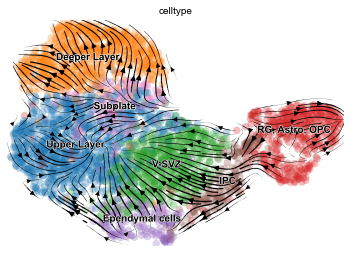

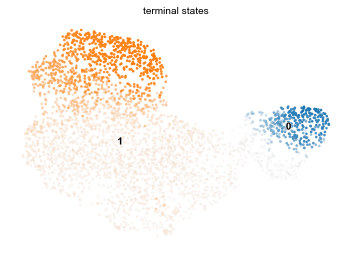

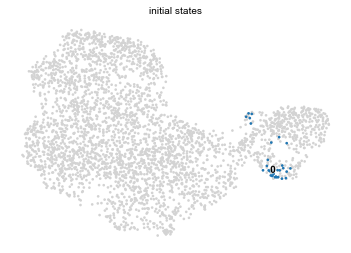

  0%|          | 0/2 [00:00<?, ?/s]

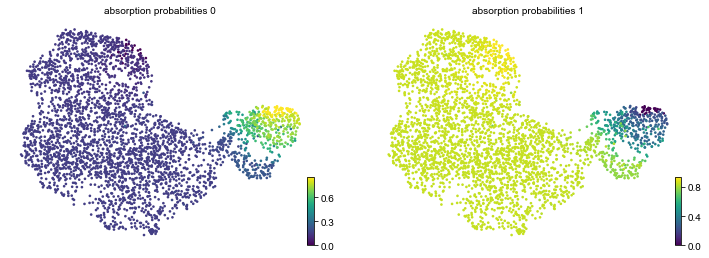

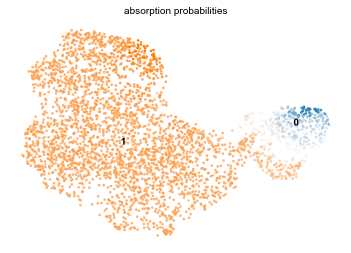

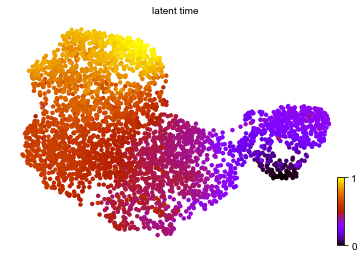

In [118]:
%%capture --no-display

scv.pl.velocity_embedding_stream(adata_rna, vkey="T_fwd", basis="umap", color='celltype')
cr.pl.terminal_states(adata_rna)
cr.pl.initial_states(adata_rna, discrete=True)
cr.pl.lineages(adata_rna, same_plot=False)
cr.pl.lineages(adata_rna, same_plot=True)
scv.pl.scatter(adata_rna, color='latent_time', color_map='gnuplot', size=80)


## MultiVelo + CellRank on RNA+ATAC

In [33]:
adata_result = sc.read_h5ad(os.path.join(result_fold, "multivelo_result.h5ad"))

In [34]:
%%capture --no-display
%%time

mv.velocity_graph(adata_result)
mv.latent_time(adata_result)

velocity = cr.tl.kernels.VelocityKernel(adata_result, vkey = 'velo_s_norm').compute_transition_matrix()

connectivity = cr.tl.kernels.ConnectivityKernel(adata_result).compute_transition_matrix()

combined_kernel = 0.9 * velocity + 0.1 * connectivity
combined_kernel = combined_kernel.compute_transition_matrix()
combined_kernel.compute_projection(basis="umap")

cr.tl.terminal_states(adata_result, n_states=2, weight_connectivities=0.2, vkey='velo_s_norm')
cr.tl.initial_states(adata_result, vkey='velo_s_norm')
cr.tl.lineages(adata_result)
scv.tl.recover_latent_time(
    adata_result, root_key="initial_states_probs", end_key="terminal_states_probs"
)

  0%|          | 0/3365 [00:00<?, ?cells/s]

  0%|          | 0/3365 [00:00<?, ?cell/s]

  0%|          | 0/3365 [00:00<?, ?cell/s]

  0%|          | 0/3365 [00:00<?, ?cell/s]

  0%|          | 0/3365 [00:00<?, ?cell/s]

  0%|          | 0/3365 [00:00<?, ?cell/s]

  0%|          | 0/3365 [00:00<?, ?cell/s]

  0%|          | 0/2 [00:00<?, ?/s]

  0%|          | 0/3365 [00:00<?, ?cells/s]

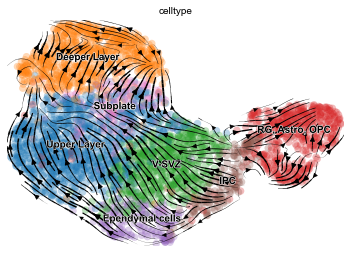

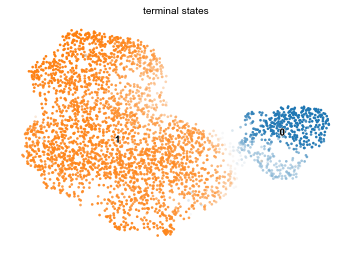

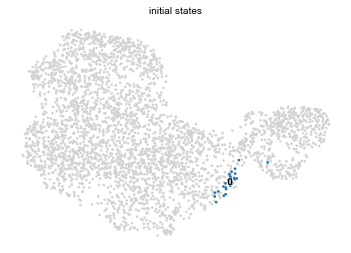

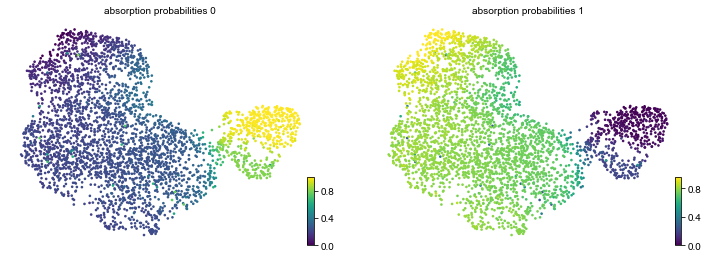

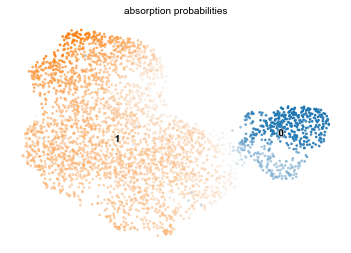

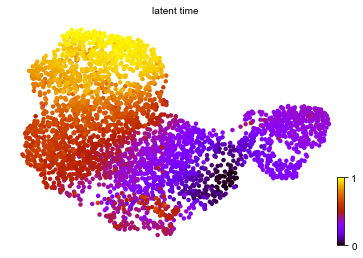

In [146]:
%%capture --no-display

scv.pl.velocity_embedding_stream(adata_result, vkey="T_fwd", basis="umap", color='celltype')
cr.pl.terminal_states(adata_result)
cr.pl.initial_states(adata_result, discrete=True)
cr.pl.lineages(adata_result, same_plot=False)
cr.pl.lineages(adata_result, same_plot=True)
scv.pl.scatter(adata_result, color='latent_time', color_map='gnuplot', size=80)

## Comparison

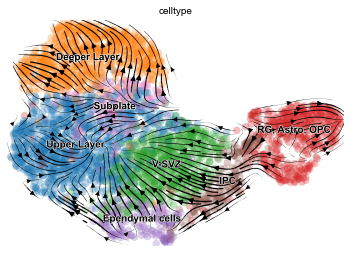

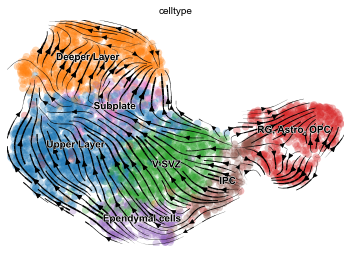

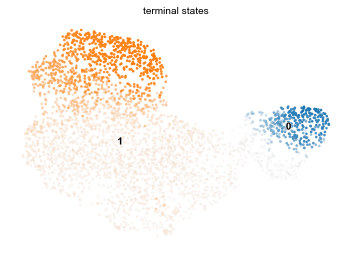

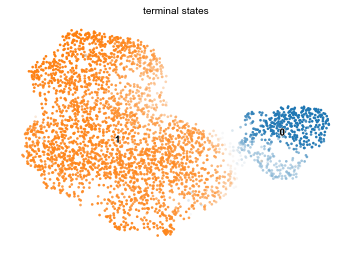

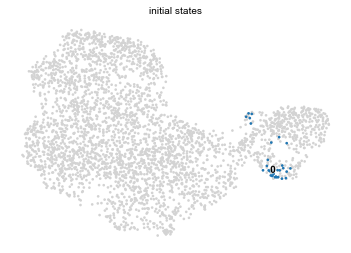

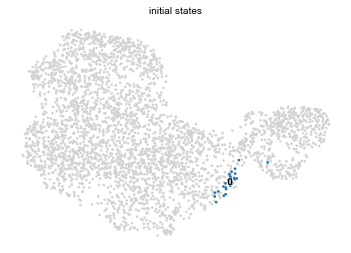

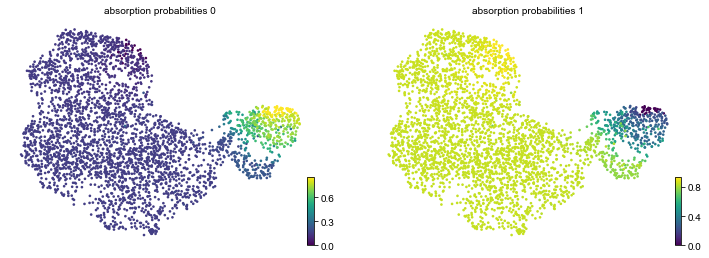

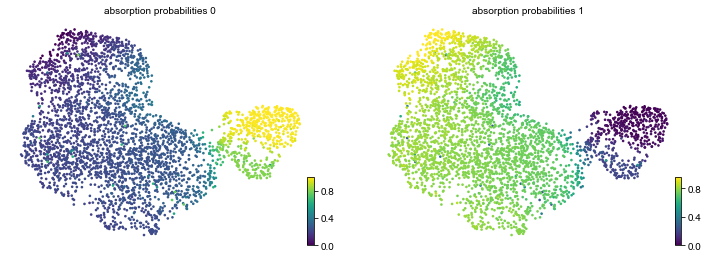

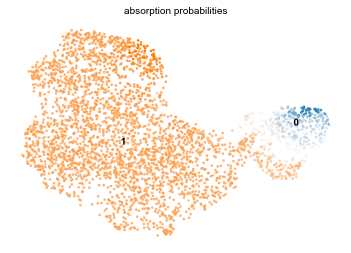

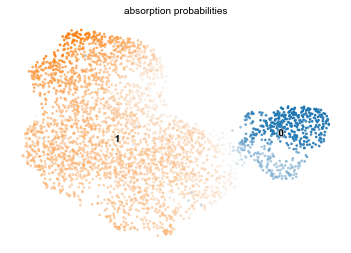

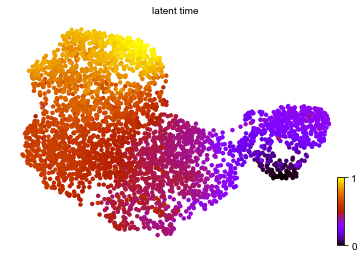

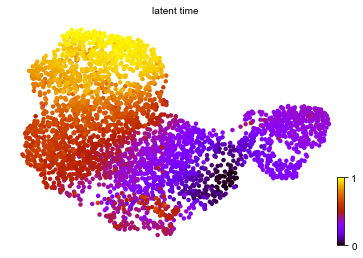

In [149]:
%%capture --no-display

scv.pl.velocity_embedding_stream(adata_rna, vkey="T_fwd", basis="umap", color='celltype')
scv.pl.velocity_embedding_stream(adata_result, vkey="T_fwd", basis="umap", color='celltype')

cr.pl.terminal_states(adata_rna)
cr.pl.terminal_states(adata_result)

cr.pl.initial_states(adata_rna, discrete=True)
cr.pl.initial_states(adata_result, discrete=True)

cr.pl.lineages(adata_rna, same_plot=False)
cr.pl.lineages(adata_result, same_plot=False)

cr.pl.lineages(adata_rna, same_plot=True)
cr.pl.lineages(adata_result, same_plot=True)

scv.pl.scatter(adata_rna, color='latent_time', color_map='gnuplot', size=80)
scv.pl.scatter(adata_result, color='latent_time', color_map='gnuplot', size=80)

## Lineages RNA

In [6]:
adata_rna

AnnData object with n_obs × n_vars = 3365 × 936
    obs: 'n_counts', 'celltype', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'neighbors', 'pca', 'umap', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

In [5]:
cr.tl.lineage_drivers(adata_rna)

<ipython-input-5-775160757f32>:1: DeprecationWarning: `cellrank.tl.lineage_drivers` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineage_drivers(adata_rna)


0_corr         0_pval         0_qval  0_ci_low  0_ci_high  \
Gene                                                                   
Mfge8    0.767647   0.000000e+00   0.000000e+00  0.753399   0.781174   
Tnc      0.752954   0.000000e+00   0.000000e+00  0.737939   0.767224   
Slc1a3   0.680574   0.000000e+00   0.000000e+00  0.662008   0.698305   
Atp1a2   0.671094   0.000000e+00   0.000000e+00  0.652091   0.689254   
Sparc    0.604037   0.000000e+00   0.000000e+00  0.582129   0.625069   
...           ...            ...            ...       ...        ...   
Celf2   -0.400311  1.792829e-133  3.995446e-132 -0.428307  -0.371547   
Tuba1a  -0.409905  1.094687e-140  2.696387e-139 -0.437634  -0.381398   
Igfbpl1 -0.422641  1.135686e-150  3.037150e-149 -0.450004  -0.394485   
Basp1   -0.423612  1.881110e-151  5.178585e-150 -0.450947  -0.395483   
Gria2   -0.472608  9.640577e-195  4.511790e-193 -0.498438  -0.445940   

           1_corr         1_pval         1_qval  1_ci_low  1_ci_high  
Gene                                                                  
Mfge8   -0.767646   0.000000e+00   0.000000e+00 -0.781173  -0.753398  
Tnc     -0.752952   0.000000e+00   0.000000e+00 -0.767222  -0.737937  
Slc1a3  -0.680574   0.000000e+00   0.000000e+00 -0.698305  -0.662008  
Atp1a2  -0.671093   0.000000e+00   0.000000e+00 -0.689253  -0.652090  
Sparc   -0.604036   0.000000e+00   0.000000e+00 -0.625068  -0.582128  
...           ...            ...            ...       ...        ...  
Celf2    0.400309  1.798962e-133  4.009115e-132  0.371545   0.428305  
Tuba1a   0.409899  1.106517e-140  2.725527e-139  0.381392   0.437628  
Igfbpl1  0.422635  1.148559e-150  3.071575e-149  0.394478   0.449998  
Basp1    0.423604  1.907204e-151  5.250421e-150  0.395475   0.450940  
Gria2    0.472605  9.713226e-195  4.545790e-193  0.445936   0.498435  

[936 rows x 10 columns]

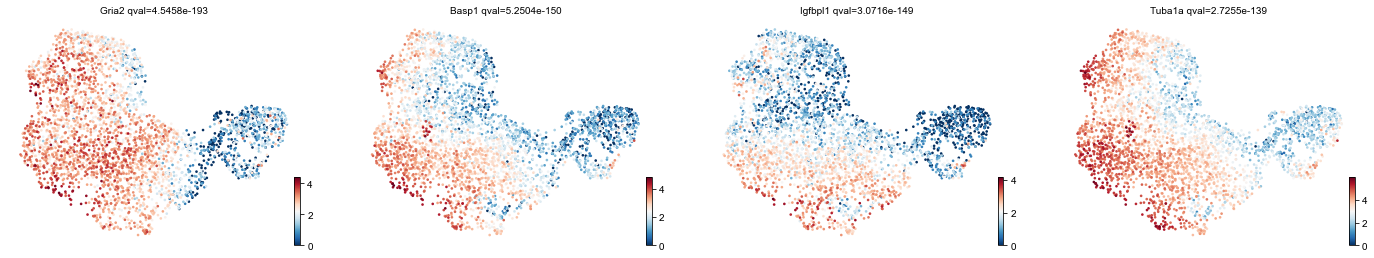

In [239]:
cr.pl.lineage_drivers(adata_rna, lineage="1", n_genes=4)

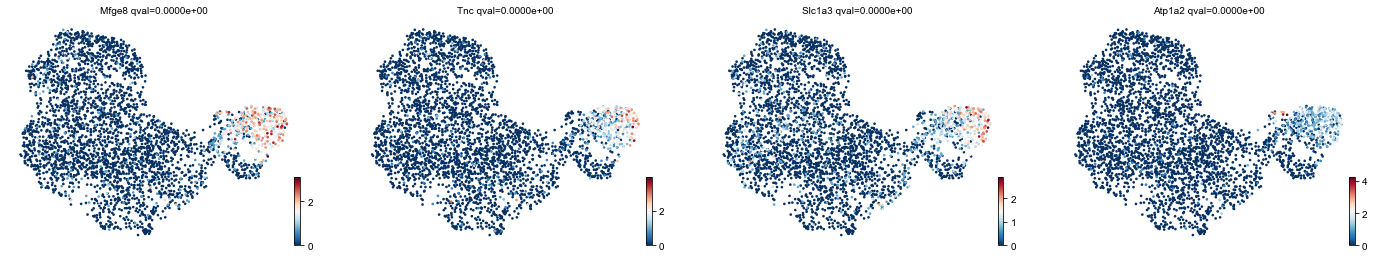

In [240]:
cr.pl.lineage_drivers(adata_rna, lineage="0", n_genes=4)

  0%|          | 0/4 [00:00<?, ?gene/s]

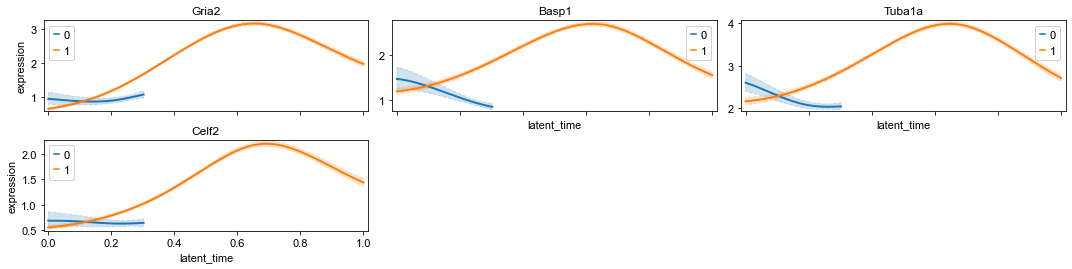

In [15]:
model = cr.ul.models.GAM(adata_rna)
cr.pl.gene_trends(
    adata_rna,
    model=model,
    data_key="X",
    genes=["Gria2", "Basp1", "Tuba1a", "Celf2"],
    ncols=3,
    time_key="latent_time",
    same_plot=True,
    hide_cells=True,
    figsize=(15, 4),
    n_test_points=200,
)

In [231]:
adata_rna.varm['terminal_lineage_drivers']["0_corr"].sort_values(ascending=False)

Gene
Mfge8      0.767647
Tnc        0.752954
Slc1a3     0.680574
Atp1a2     0.671094
Sparc      0.604037
             ...   
Celf2     -0.400311
Tuba1a    -0.409905
Igfbpl1   -0.422641
Basp1     -0.423612
Gria2     -0.472608
Name: 0_corr, Length: 936, dtype: float64

In [233]:
adata_rna.varm['terminal_lineage_drivers']["1_corr"].abs().sort_values(ascending=False)

Gene
Mfge8            0.767646
Tnc              0.752952
Slc1a3           0.680574
Atp1a2           0.671093
Sparc            0.604036
                   ...   
2810403D21Rik    0.000984
Grin3a           0.000964
Abcd2            0.000619
Bsg              0.000230
Parm1            0.000186
Name: 1_corr, Length: 936, dtype: float64

  0%|          | 0/100 [00:00<?, ?gene/s]

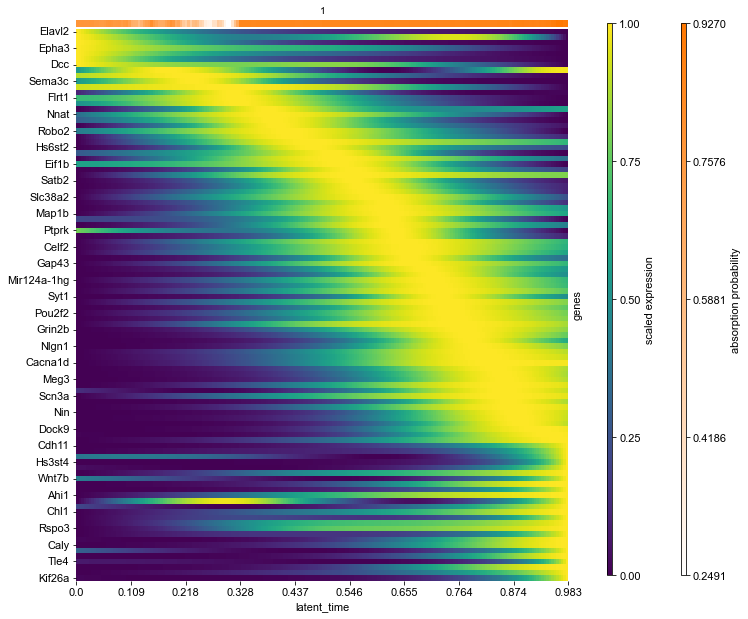

In [236]:
cr.pl.heatmap(
    adata_rna,
    model,
    genes=adata_rna.varm['terminal_lineage_drivers']["1_corr"].sort_values(ascending=False).index[:100],
    show_absorption_probabilities=True,
    lineages="1",
    n_jobs=1,
    backend="loky",
)

  0%|          | 0/100 [00:00<?, ?gene/s]

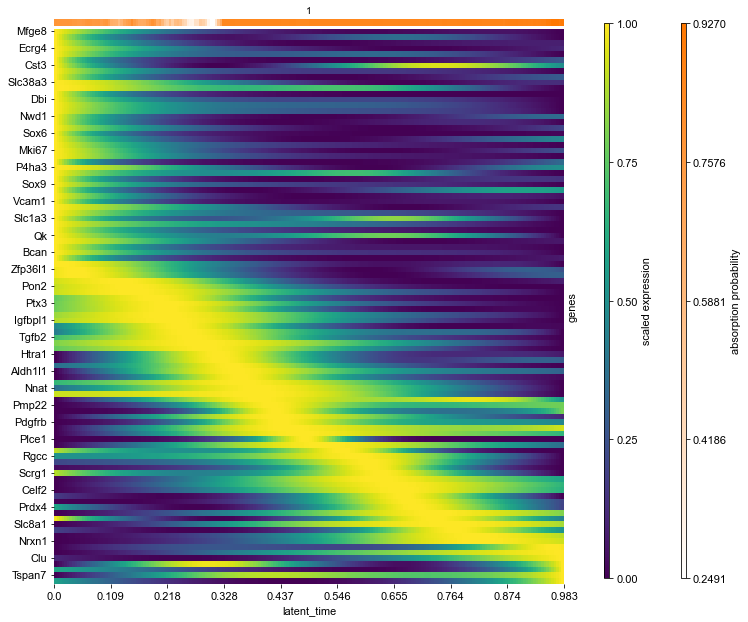

In [234]:
cr.pl.heatmap(
    adata_rna,
    model,
    genes=adata_rna.varm['terminal_lineage_drivers']["1_corr"].abs().sort_values(ascending=False).index[:100],
    show_absorption_probabilities=True,
    lineages="1",
    n_jobs=1,
    backend="loky",
)

  0%|          | 0/100 [00:00<?, ?gene/s]

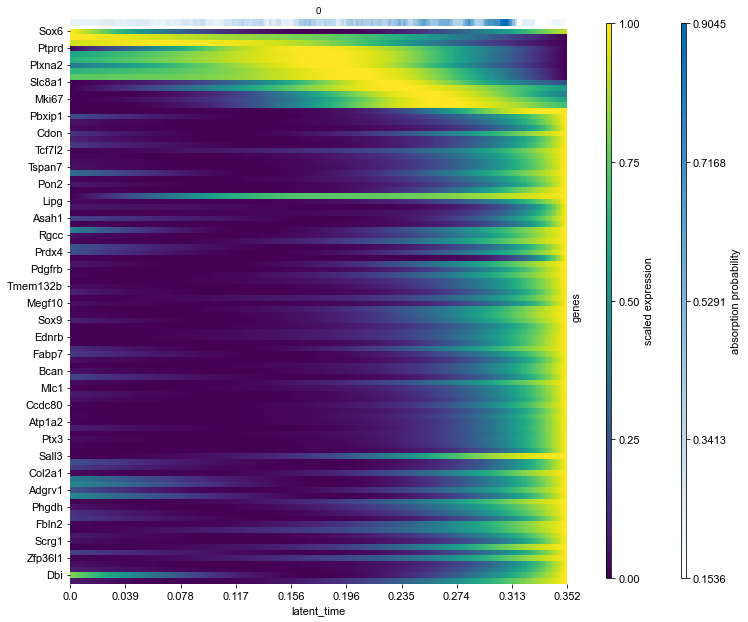

In [235]:
cr.pl.heatmap(
    adata_rna,
    model,
    genes=adata_rna.varm['terminal_lineage_drivers']["0_corr"].abs().sort_values(ascending=False).index[:100],
    show_absorption_probabilities=True,
    lineages="0",
    n_jobs=1,
    backend="loky",
)

  0%|          | 0/4 [00:00<?, ?gene/s]

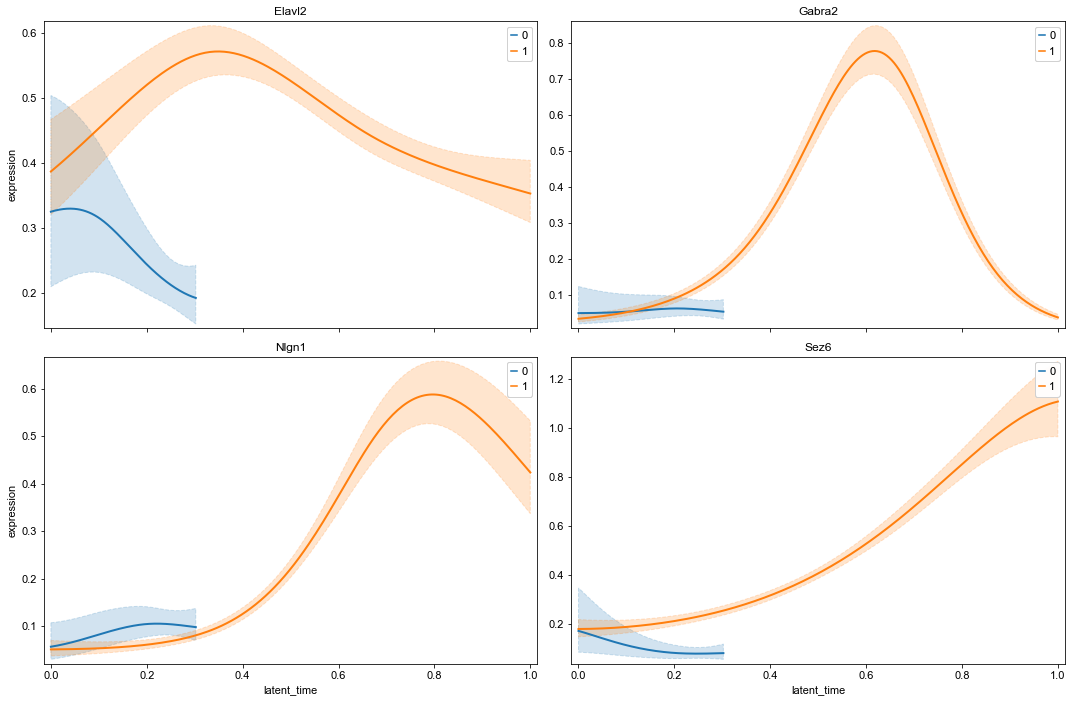

In [28]:
model = cr.ul.models.GAM(adata_rna)
cr.pl.gene_trends(
    adata_rna,
    model=model,
    data_key="X",
    genes=["Elavl2", "Gabra2", "Nlgn1", "Sez6"],
    ncols=2,
    time_key="latent_time",
    same_plot=True,
    hide_cells=True,
    figsize=(15, 10),
    n_test_points=200,
)


  0%|          | 0/3 [00:00<?, ?gene/s]

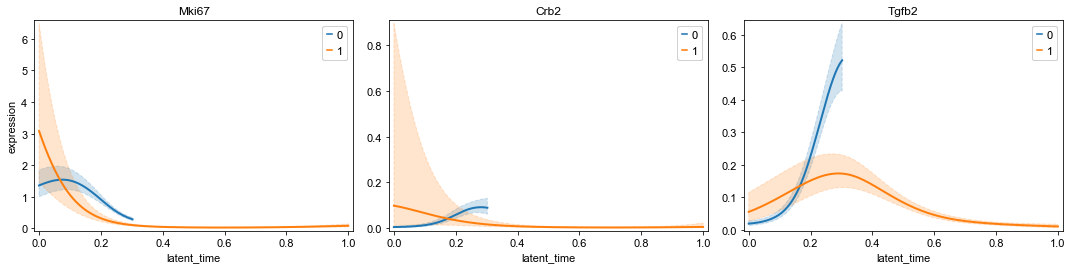

In [31]:
model = cr.ul.models.GAM(adata_rna)
cr.pl.gene_trends(
    adata_rna,
    model=model,
    data_key="X",
    genes=["Mki67","Crb2", "Tgfb2"],
    ncols=3,
    time_key="latent_time",
    same_plot=True,
    hide_cells=True,
    figsize=(15, 4),
    n_test_points=200,
)

## Lineages RNA+ATAC

In [35]:
adata_result

AnnData object with n_obs × n_vars = 3365 × 865
    obs: 'n_counts', 'celltype', 'velo_s_norm_self_transition', 'root_cells', 'end_points', 'velo_s_norm_pseudotime', 'latent_time', 'terminal_states', 'terminal_states_probs', 'initial_states', 'initial_states_probs', 'velocity_self_transition', 'velocity_pseudotime'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_alpha_c', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_sw1', 'fit_t_sw2', 'fit_t_sw3', 'fit_scale_cc', 'fit_rescale_c', 'fit_rescale_u', 'fit_alignment_scaling', 'fit_model', 'fit_direction', 'fit_loss', 'fit_likelihood', 'fit_likelihood_c', 'fit_ssd_c', 'fit_var_c', 'fit_c0', 'fit_u0', 'fit_s0', 'fit_anchor_min_idx', 'fit_anchor_max_idx', 'fit_anchor_velo_min_idx', 'fit_anchor_velo_max_idx', 'velo_s_genes', 'velo_u_genes', 'velo_chrom_genes', 'velo_s_norm_genes', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'celltype_colors', 'neighbors', 'pca', 'umap', 'velo_chrom_params

In [36]:
cr.tl.lineage_drivers(adata_result)

<ipython-input-36-de2d912dd412>:1: DeprecationWarning: `cellrank.tl.lineage_drivers` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineage_drivers(adata_result)


0_corr         0_pval         0_qval  0_ci_low  0_ci_high    1_corr  \
Gene                                                                            
Mfge8   0.706101   0.000000e+00   0.000000e+00  0.688744   0.722649 -0.706100   
Tnc     0.624393   0.000000e+00   0.000000e+00  0.603333   0.644583 -0.624393   
Slc1a3  0.590136   0.000000e+00   0.000000e+00  0.567665   0.611727 -0.590135   
Atp1a2  0.588187   0.000000e+00   0.000000e+00  0.565639   0.609856 -0.588187   
Sparc   0.579395   0.000000e+00   0.000000e+00  0.556500   0.601410 -0.579395   
...          ...            ...            ...       ...        ...       ...   
Basp1  -0.546065  1.731522e-276  1.361606e-274 -0.569349  -0.521905  0.546065   
Celf2  -0.580586   0.000000e+00   0.000000e+00 -0.602555  -0.557738  0.580587   
Tuba1a -0.581462   0.000000e+00   0.000000e+00 -0.603397  -0.558649  0.581464   
Rtn1   -0.619391   0.000000e+00   0.000000e+00 -0.639791  -0.598120  0.619392   
Gria2  -0.693105   0.000000e+00   0.000000e+00 -0.710260  -0.675127  0.693104   

               1_pval         1_qval  1_ci_low  1_ci_high  
Gene                                                       
Mfge8    0.000000e+00   0.000000e+00 -0.722649  -0.688743  
Tnc      0.000000e+00   0.000000e+00 -0.644583  -0.603332  
Slc1a3   0.000000e+00   0.000000e+00 -0.611727  -0.567665  
Atp1a2   0.000000e+00   0.000000e+00 -0.609856  -0.565639  
Sparc    0.000000e+00   0.000000e+00 -0.601410  -0.556500  
...               ...            ...       ...        ...  
Basp1   1.729766e-276  1.360225e-274  0.521906   0.569350  
Celf2    0.000000e+00   0.000000e+00  0.557739   0.602556  
Tuba1a   0.000000e+00   0.000000e+00  0.558650   0.603398  
Rtn1     0.000000e+00   0.000000e+00  0.598121   0.639792  
Gria2    0.000000e+00   0.000000e+00  0.675126   0.710260  

[865 rows x 10 columns]

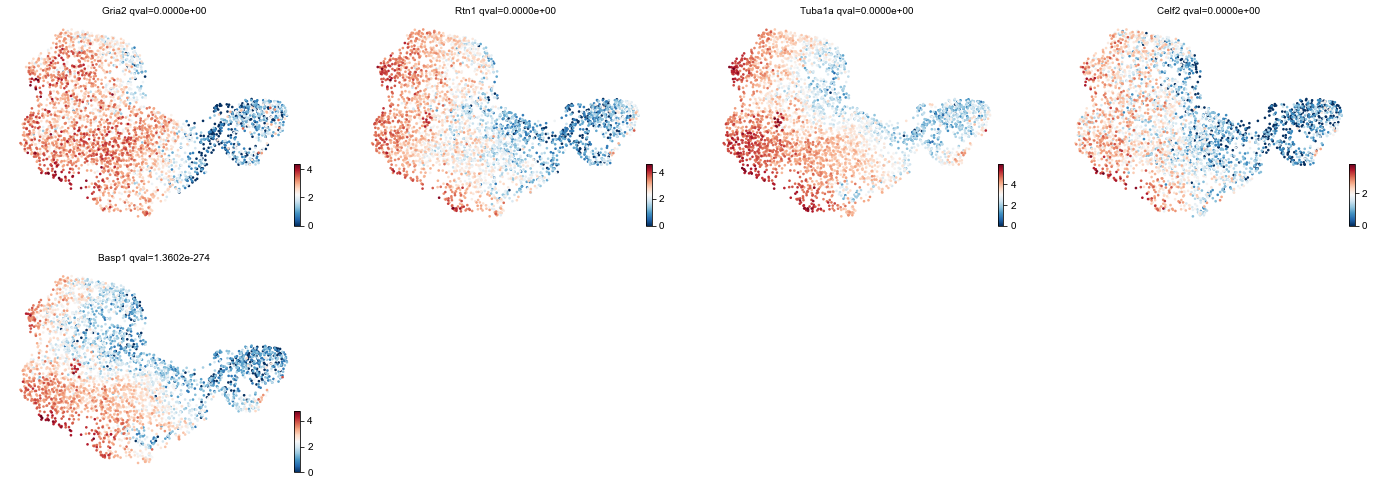

In [39]:
cr.pl.lineage_drivers(adata_result, lineage="1", n_genes=5)

In [ ]:
model = cr.ul.models.GAM(adata_result)

  0%|          | 0/5 [00:00<?, ?gene/s]

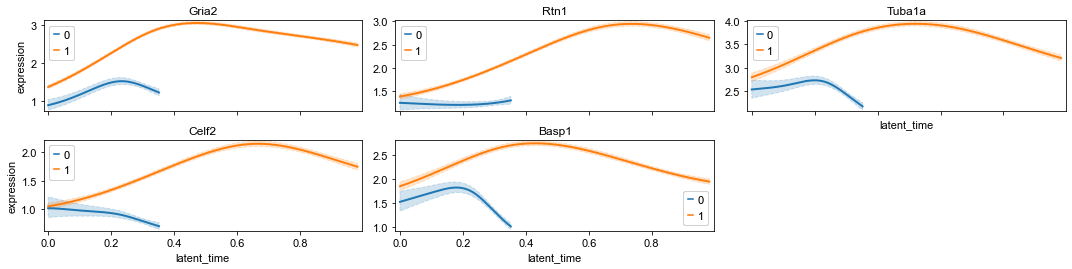

In [48]:
cr.pl.gene_trends(
    adata_result,
    model=model,
    data_key="X",
    genes=["Gria2", "Rtn1", "Tuba1a", "Celf2", "Basp1"],
    ncols=3,
    time_key="latent_time",
    same_plot=True,
    hide_cells=True,
    figsize=(15, 4),
    n_test_points=200,
)

  0%|          | 0/100 [00:00<?, ?gene/s]

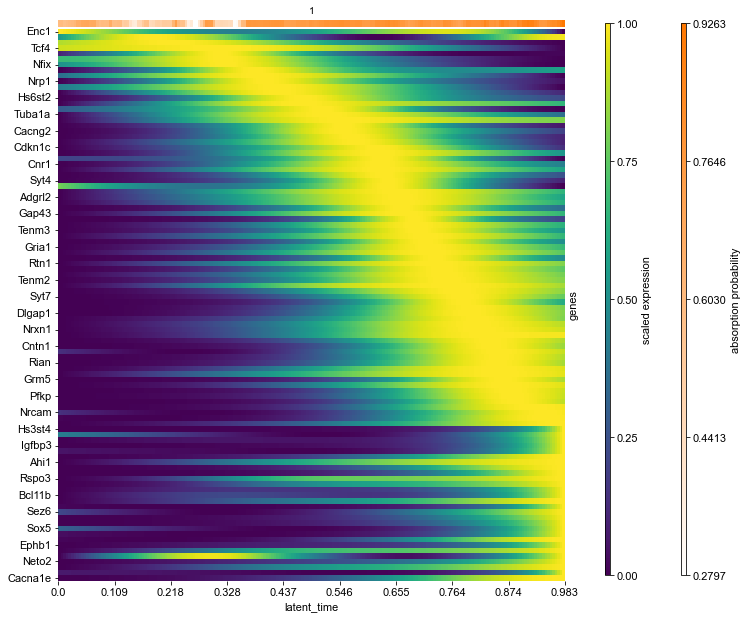

In [49]:
cr.pl.heatmap(
    adata_result,
    model,
    genes=adata_result.varm['terminal_lineage_drivers']["1_corr"].sort_values(ascending=False).index[:100],
    show_absorption_probabilities=True,
    lineages="1",
    n_jobs=1,
    backend="loky",
)

  0%|          | 0/3 [00:00<?, ?gene/s]

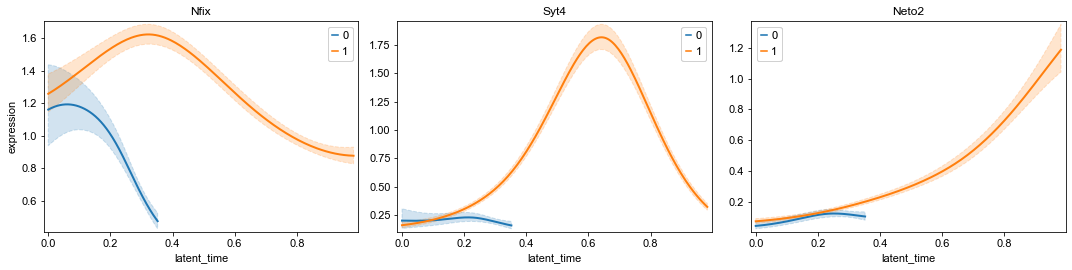

In [54]:
model = cr.ul.models.GAM(adata_result)
cr.pl.gene_trends(
    adata_result,
    model=model,
    data_key="X",
    genes=["Nfix", "Syt4", "Neto2"],
    ncols=3,
    time_key="latent_time",
    same_plot=True,
    hide_cells=True,
    figsize=(15, 4),
    n_test_points=200,
)

  0%|          | 0/100 [00:00<?, ?gene/s]

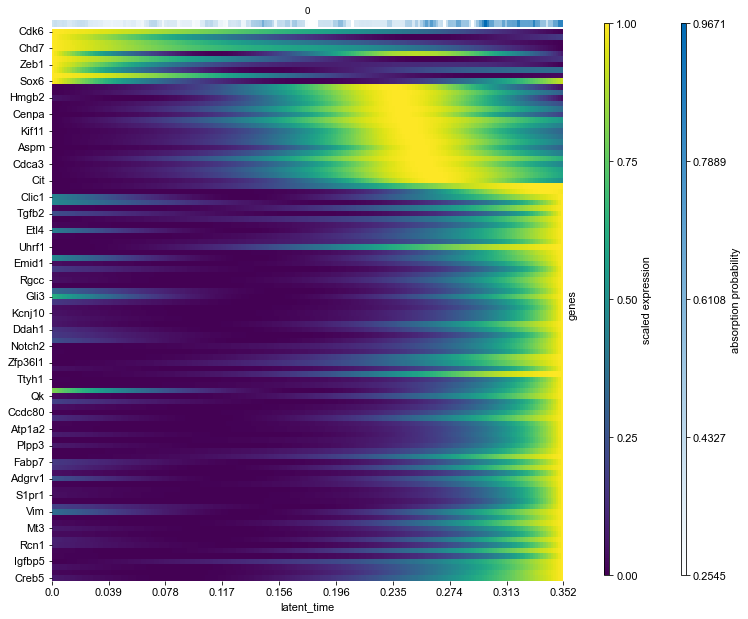

In [53]:
cr.pl.heatmap(
    adata_result,
    model,
    genes=adata_result.varm['terminal_lineage_drivers']["0_corr"].sort_values(ascending=False).index[:100],
    show_absorption_probabilities=True,
    lineages="0",
    n_jobs=1,
    backend="loky",
)

  0%|          | 0/3 [00:00<?, ?gene/s]

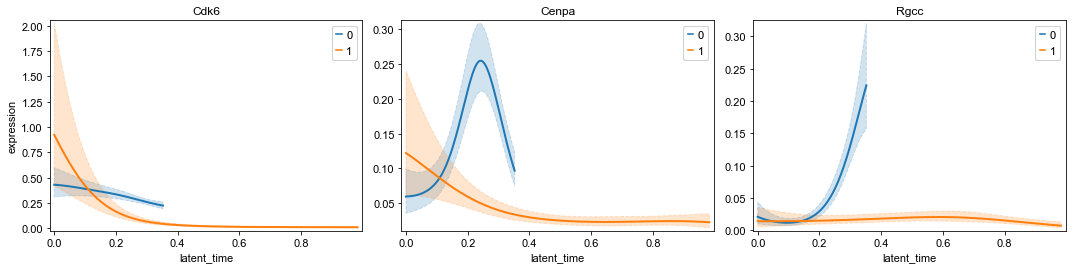

In [55]:
model = cr.ul.models.GAM(adata_result)
cr.pl.gene_trends(
    adata_result,
    model=model,
    data_key="X",
    genes=["Cdk6", "Cenpa", "Rgcc"],
    ncols=3,
    time_key="latent_time",
    same_plot=True,
    hide_cells=True,
    figsize=(15, 4),
    n_test_points=200,
)

In [227]:
n = 100
result_corr_0 = adata_result.varm['terminal_lineage_drivers']["0_corr"].sort_values(ascending=False).iloc[:n]
result_corr_1 = adata_result.varm['terminal_lineage_drivers']["1_corr"].sort_values(ascending=False).iloc[:n]
rna_corr_0 = adata_rna.varm['terminal_lineage_drivers']["0_corr"].sort_values(ascending=False).iloc[:n]
rna_corr_1 = adata_rna.varm['terminal_lineage_drivers']["1_corr"].sort_values(ascending=False).iloc[:n]

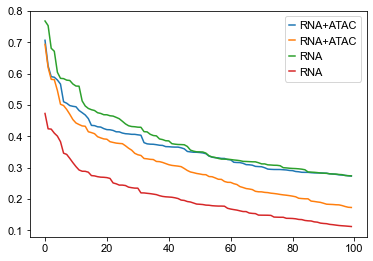

In [228]:
plt.plot(result_corr_0.to_numpy(), label='RNA+ATAC')
plt.plot(result_corr_1.to_numpy(), label='RNA+ATAC')
plt.plot(rna_corr_0.to_numpy(), label='RNA')
plt.plot(rna_corr_1.to_numpy(), label='RNA')
plt.legend()

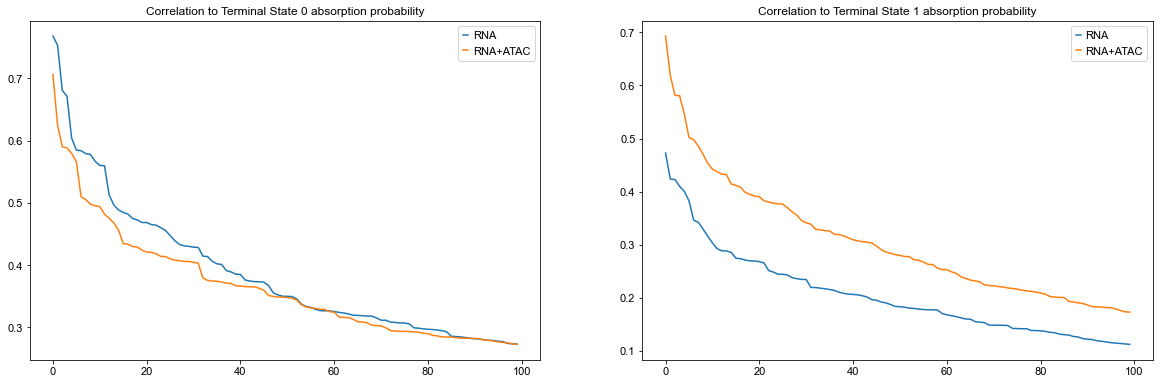

In [229]:
fig, ax = plt.subplots(1,2, figsize=(20, 6))
ax = ax.flatten()
ax[0].plot(rna_corr_0.to_numpy(), label='RNA')
ax[1].plot(rna_corr_1.to_numpy(), label='RNA')
ax[0].plot(result_corr_0.to_numpy(), label='RNA+ATAC')
ax[1].plot(result_corr_1.to_numpy(), label='RNA+ATAC')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Correlation to Terminal State 0 absorption probability')
ax[1].set_title('Correlation to Terminal State 1 absorption probability')
plt.show()

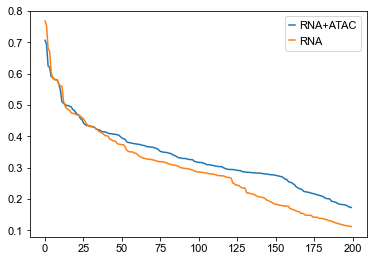

In [216]:
plt.plot(sorted(list(result_corr_0) + list(result_corr_1))[::-1], label='RNA+ATAC')
plt.plot(sorted(list(rna_corr_0) + list(rna_corr_1))[::-1], label='RNA')
plt.legend()
plt.show()

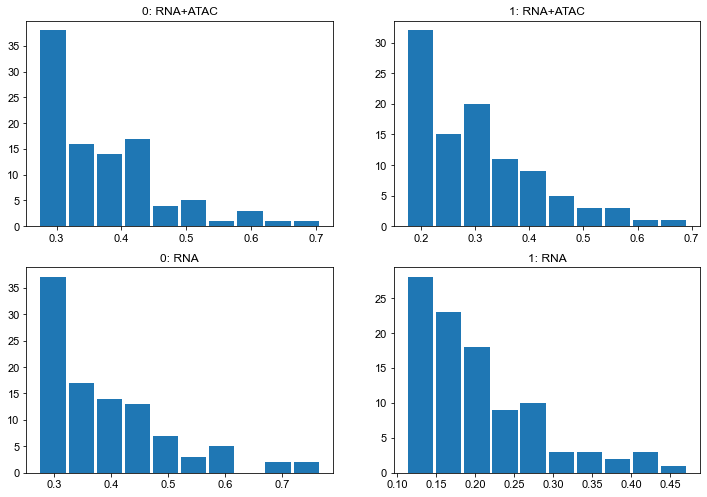

In [109]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
ax = ax.flatten()

ax[0].hist(result_corr_0, rwidth=0.9)
ax[0].set_title('0: RNA+ATAC')
ax[1].hist(result_corr_1, rwidth=0.9)
ax[1].set_title('1: RNA+ATAC')
ax[2].hist(rna_corr_0, rwidth=0.9)
ax[2].set_title('0: RNA')
ax[3].hist(rna_corr_1, rwidth=0.9)
ax[3].set_title('1: RNA')

plt.show()

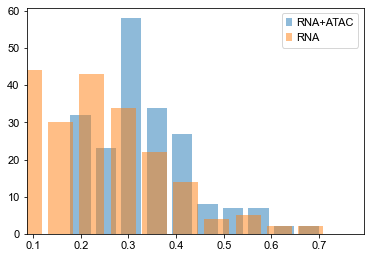

In [130]:
plt.figure(figsize=(6,4))

plt.hist(list(result_corr_0)+list(result_corr_1), rwidth=0.8, alpha=0.5, label='RNA+ATAC')
plt.hist(list(rna_corr_0)+list(rna_corr_1), rwidth=0.8, alpha=0.5, label='RNA')

plt.legend()
plt.show()

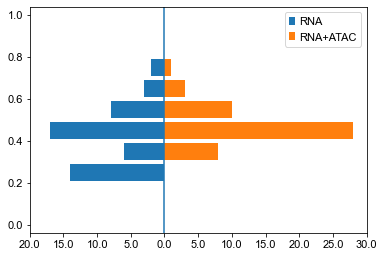

In [225]:
import numpy as np
from matplotlib import pylab as pl


n = 25


result_corr_0 = adata_result.varm['terminal_lineage_drivers']["0_corr"].sort_values(ascending=False).iloc[:n]
result_corr_1 = adata_result.varm['terminal_lineage_drivers']["1_corr"].sort_values(ascending=False).iloc[:n]
rna_corr_0 = adata_rna.varm['terminal_lineage_drivers']["0_corr"].sort_values(ascending=False).iloc[:n]
rna_corr_1 = adata_rna.varm['terminal_lineage_drivers']["1_corr"].sort_values(ascending=False).iloc[:n]



dataATAC = list(result_corr_0)+list(result_corr_1)
dataRNA = list(rna_corr_0)+list(rna_corr_1)

hN = pl.hist(dataRNA, orientation='horizontal', range=(0,1),  rwidth=0.8, label='RNA')
hS = pl.hist(dataATAC, bins=hN[1], range=(0,1), orientation='horizontal',  
    rwidth=0.8, label='RNA+ATAC')

for p in hN[2]:
    p.set_width( - p.get_width())

xmin = min([ min(w.get_width() for w in hN[2]), 
                min([w.get_width() for w in hS[2]]) ])
xmin = np.floor(xmin)
xmax = max([ max(w.get_width() for w in hN[2]), 
                max([w.get_width() for w in hS[2]]) ])
xmax = np.ceil(xmax)
s_range = xmax - xmin
delta = 0.0 * s_range
pl.xlim([xmin - delta, xmax + delta])
xt = pl.xticks()
n = xt[0]
s = ['%.1f'%abs(i) for i in n]
pl.xticks(n, s)
pl.legend(loc='best')
pl.axvline(0.0)
pl.show()

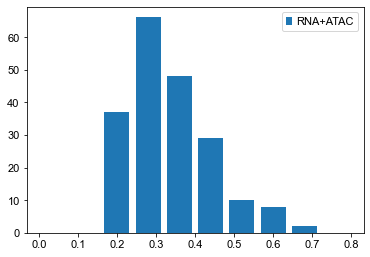

In [140]:
plt.figure(figsize=(6,4))

plt.hist(list(result_corr_0)+list(result_corr_1), rwidth=0.8, range=(0,0.8),label='RNA+ATAC')
plt.hist(list(rna_corr_0)+list(rna_corr_1), rwidth=0.8, label='RNA')

plt.legend()
plt.show()

In [242]:
print( *rna_corr_0[:50].index, sep='\n')

Mfge8
Tnc
Slc1a3
Atp1a2
Sparc
Ttyh1
Ccdc80
Pdpn
Plpp3
Mlc1
Qk
Slco1c1
Fgfbp3
Bcan
Vit
Clu
Fabp7
Notch1
Pmp22
Ednrb
Notch2
Ptx3
Vcam1
Ccn1
Sall3
Rcn1
S1pr1
Zfp36l1
Cd9
Htra1
Scrg1
Mt3
Igfbp5
Fbln2
Dbi
Fstl1
Phgdh
Aldoc
Ecrg4
Sfrp1
Adgrv1
Cst3
Col2a1
Smpdl3a
Sox9
Tgfb2
Slc38a3
Ddah1
Rfx4
Megf10


In [268]:
s = """ZHONG_PFC_MAJOR_TYPES_ASTROCYTES
MANNO_MIDBRAIN_NEUROTYPES_HRGL2A
FAN_EMBRYONIC_CTX_BIG_GROUPS_GLIAL
MANNO_MIDBRAIN_NEUROTYPES_HRGL2B
ZHONG_PFC_C9_ORG_OTHER
MANNO_MIDBRAIN_NEUROTYPES_HRGL2C
MANNO_MIDBRAIN_NEUROTYPES_HRGL3
MANNO_MIDBRAIN_NEUROTYPES_HRGL1
LEIN_ASTROCYTE_MARKERS
MANNO_MIDBRAIN_NEUROTYPES_HOPC
FAN_EMBRYONIC_CTX_ASTROCYTE_2
MURARO_PANCREAS_MESENCHYMAL_STROMAL_CELL
HAY_BONE_MARROW_STROMAL
ZHONG_PFC_MAJOR_TYPES_OPC
GOBP_REGULATION_OF_CELL_POPULATION_PROLIFERATION
GOCC_COLLAGEN_CONTAINING_EXTRACELLULAR_MATRIX
GOCC_EXTERNAL_ENCAPSULATING_STRUCTURE
DURANTE_ADULT_OLFACTORY_NEUROEPITHELIUM_OLFACTORY_ENSHEATHING_GLIA
GOBP_CELL_ADHESION
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"""

In [269]:
rna_pathways_0 = eval("['"+s.replace("\n","','")+"']")

In [270]:
print( *result_corr_0[:50].index, sep='\n')

Mfge8
Tnc
Slc1a3
Atp1a2
Sparc
Notch1
Ccdc80
Pdpn
Slco1c1
Plpp3
Qk
Mlc1
Mki67
Ttyh1
Sall3
Bcan
Zfp36l1
Top2a
Ecrg4
Vit
Notch2
Dbi
Ednrb
Htra1
Fabp7
Phgdh
Cenpf
Igfbp5
Ccnd2
Vcam1
Fbln2
Rcn1
Sox9
Knl1
Ptx3
Mt3
Col2a1
Pmp22
Vim
Cd9
Ccn1
S1pr1
Clu
Mdk
Slc38a3
Adgrv1
Scrg1
Cenpe
Hmgb2
Fstl1


In [271]:
s ="""ZHONG_PFC_MAJOR_TYPES_ASTROCYTES	FAN_EMBRYONIC_CTX_BIG_GROUPS_GLIAL	MANNO_MIDBRAIN_NEUROTYPES_HRGL2B	MANNO_MIDBRAIN_NEUROTYPES_HRGL2A	ZHONG_PFC_C9_ORG_OTHER	MANNO_MIDBRAIN_NEUROTYPES_HRGL3	MANNO_MIDBRAIN_NEUROTYPES_HRGL2C	MANNO_MIDBRAIN_NEUROTYPES_HPROGBP	MANNO_MIDBRAIN_NEUROTYPES_HRGL1	MANNO_MIDBRAIN_NEUROTYPES_HPROGFPL	MANNO_MIDBRAIN_NEUROTYPES_HPROGFPM	MANNO_MIDBRAIN_NEUROTYPES_HOPC	MURARO_PANCREAS_MESENCHYMAL_STROMAL_CELL	ZHONG_PFC_MAJOR_TYPES_NPCS	MANNO_MIDBRAIN_NEUROTYPES_HPROGM	DURANTE_ADULT_OLFACTORY_NEUROEPITHELIUM_OLFACTORY_ENSHEATHING_GLIA	GOBP_REGULATION_OF_CELL_POPULATION_PROLIFERATION	LEIN_ASTROCYTE_MARKERS	HAY_BONE_MARROW_STROMAL	HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"""


In [272]:
result_pathways_0 = eval("['"+s.replace("	","','")+"']")

In [273]:
print( *rna_corr_1[:50].index, sep='\n')

Gria2
Basp1
Igfbpl1
Tuba1a
Celf2
Rtn1
Tmsb10
Ahi1
Ptprd
Map1b
Slc8a1
Nnat
Nrxn1
Plxna2
Scn3a
Id2
Sez6
Adgrl3
Enc1
Cnr1
Grin2b
Arpp21
Nfix
Chl1
Plxna4
Runx1t1
Atp2b1
Nrp1
Syt4
Scn2a
Tenm2
Mef2c
Epha5
Bcl11b
Mir124a-1hg
Gap43
Satb2
Robo2
Adgrl2
Pcdh9
Meg3
Syt1
Syt7
Flrt1
Xpr1
Neto2
Lmo4
B3galt2
Gabra2
Cacna1e


In [274]:
s = """MANNO_MIDBRAIN_NEUROTYPES_HNBGABA	MANNO_MIDBRAIN_NEUROTYPES_HGABA	MANNO_MIDBRAIN_NEUROTYPES_HDA1	MANNO_MIDBRAIN_NEUROTYPES_HNBML5	MANNO_MIDBRAIN_NEUROTYPES_HDA2	MANNO_MIDBRAIN_NEUROTYPES_HDA	GOBP_GENERATION_OF_NEURONS	GOCC_NEURON_PROJECTION	ZHONG_PFC_C3_MICROGLIA	GOBP_NEUROGENESIS	ZHONG_PFC_C3_ASTROCYTE	BLALOCK_ALZHEIMERS_DISEASE_DN	GOCC_SYNAPSE	GOBP_NEURON_DEVELOPMENT	MANNO_MIDBRAIN_NEUROTYPES_HRN	GOBP_CENTRAL_NERVOUS_SYSTEM_DEVELOPMENT	MANNO_MIDBRAIN_NEUROTYPES_HNBML1	GOBP_CELL_PROJECTION_ORGANIZATION	GOBP_HEAD_DEVELOPMENT	MANNO_MIDBRAIN_NEUROTYPES_HSERT"""


In [275]:
rna_pathways_1 = eval("['"+s.replace("	","','")+"']")

In [276]:
rna_pathways_1

['MANNO_MIDBRAIN_NEUROTYPES_HNBGABA',
 'MANNO_MIDBRAIN_NEUROTYPES_HGABA',
 'MANNO_MIDBRAIN_NEUROTYPES_HDA1',
 'MANNO_MIDBRAIN_NEUROTYPES_HNBML5',
 'MANNO_MIDBRAIN_NEUROTYPES_HDA2',
 'MANNO_MIDBRAIN_NEUROTYPES_HDA',
 'GOBP_GENERATION_OF_NEURONS',
 'GOCC_NEURON_PROJECTION',
 'ZHONG_PFC_C3_MICROGLIA',
 'GOBP_NEUROGENESIS',
 'ZHONG_PFC_C3_ASTROCYTE',
 'BLALOCK_ALZHEIMERS_DISEASE_DN',
 'GOCC_SYNAPSE',
 'GOBP_NEURON_DEVELOPMENT',
 'MANNO_MIDBRAIN_NEUROTYPES_HRN',
 'GOBP_CENTRAL_NERVOUS_SYSTEM_DEVELOPMENT',
 'MANNO_MIDBRAIN_NEUROTYPES_HNBML1',
 'GOBP_CELL_PROJECTION_ORGANIZATION',
 'GOBP_HEAD_DEVELOPMENT',
 'MANNO_MIDBRAIN_NEUROTYPES_HSERT']

In [277]:
print(*result_corr_1[:50].index, sep='\n')

Gria2
Rtn1
Tuba1a
Celf2
Basp1
Ahi1
Map1b
Ptprd
Tmsb10
Nrxn1
Igfbpl1
Grin2b
Slc8a1
Id2
Scn3a
Adgrl3
Cnr1
Arpp21
Tenm2
Atp2b1
Chl1
Enc1
Runx1t1
Mef2c
Sez6
Malat1
Scn2a
Epha5
Gap43
Syt4
Nfix
Nnat
Pcdh9
Plxna2
Neto2
Xpr1
B3galt2
Nrp1
Bcl11b
Syt1
Meg3
Satb2
Adgrl2
Opcml
Plxna4
Pcdh7
Caly
Cacna1e
Ntm
Grm5


In [278]:
s ="""MANNO_MIDBRAIN_NEUROTYPES_HNBGABA	MANNO_MIDBRAIN_NEUROTYPES_HGABA	MANNO_MIDBRAIN_NEUROTYPES_HNBML5	MANNO_MIDBRAIN_NEUROTYPES_HDA2	MANNO_MIDBRAIN_NEUROTYPES_HDA1	MANNO_MIDBRAIN_NEUROTYPES_HDA	GOBP_GENERATION_OF_NEURONS	GOBP_NEUROGENESIS	MANNO_MIDBRAIN_NEUROTYPES_HSERT	ZHONG_PFC_C3_MICROGLIA	ZHONG_PFC_C3_ASTROCYTE	GOCC_SYNAPSE	GOCC_NEURON_PROJECTION	BLALOCK_ALZHEIMERS_DISEASE_DN	GOBP_NEURON_DEVELOPMENT	GOBP_HEAD_DEVELOPMENT	MANNO_MIDBRAIN_NEUROTYPES_HRN	GOBP_CENTRAL_NERVOUS_SYSTEM_DEVELOPMENT	MANNO_MIDBRAIN_NEUROTYPES_HNBML1	ZHONG_PFC_C7_ORG_UNDERGOING_NEURONAL_DIFFERENTIATION"""


In [279]:
result_pathways_1 = eval("['"+s.replace("	","','")+"']")

In [281]:
len(rna_pathways_0)

20

In [280]:
len(set(rna_pathways_0).intersection(result_pathways_0))

15

In [282]:
len(set(rna_pathways_1).intersection(result_pathways_1))

19

## Do some data science

In [491]:
specific_rows = list(range(9,30))

def get_df(fn):
    df = pd.read_table(os.path.join(result_fold, fn), skiprows = lambda x: x not in specific_rows)
    df = df[['Gene Set Name', 'k/K', 'FDR q-value']] 
    df['neglog_FDR'] = - np.log10(df['FDR q-value'])
    
    return df

In [492]:
df_rna_0 = get_df('GSEA_overlap_rna_0.tsv')
df_result_0 = get_df('GSEA_overlap_result_0.tsv')
df_rna_1 = get_df('GSEA_overlap_rna_1.tsv')
df_result_1 = get_df('GSEA_overlap_result_1.tsv')

list_df = [df_rna_0, df_result_0, df_rna_1, df_result_1]

In [493]:
df_rna_0.head()

Gene Set Name     k/K   FDR q-value  neglog_FDR
0    ZHONG_PFC_MAJOR_TYPES_ASTROCYTES  0.1043  3.070000e-56   55.512862
1    MANNO_MIDBRAIN_NEUROTYPES_HRGL2A  0.0517  8.050000e-41   40.094204
2  FAN_EMBRYONIC_CTX_BIG_GROUPS_GLIAL  0.1654  1.180000e-38   37.928118
3    MANNO_MIDBRAIN_NEUROTYPES_HRGL2B  0.0592  8.960000e-35   34.047692
4              ZHONG_PFC_C9_ORG_OTHER  0.2169  2.720000e-33   32.565431

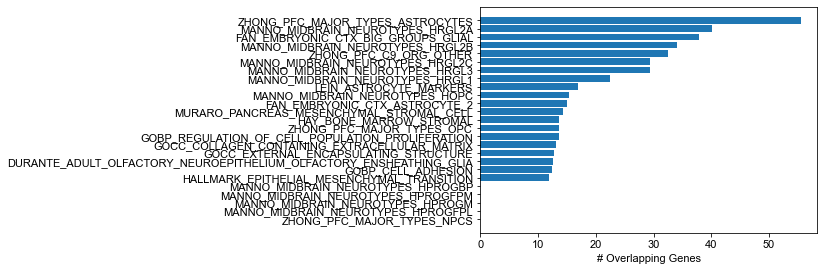

In [494]:
fig, ax = plt.subplots()

missing_rna_0 = set(df_result_0['Gene Set Name'].values) - set(df_rna_0['Gene Set Name'].values) 

x = list(df_rna_0['Gene Set Name'].values)
heights = list(df_rna_0['neglog_FDR'].values)

for gsn in missing_rna_0:
    x.append(gsn)
    heights.append(0)
y_pos = np.arange(len(x))

ax.barh(y_pos, heights, align='center')
ax.set_yticks(y_pos, labels=x)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('# Overlapping Genes')
plt.show()

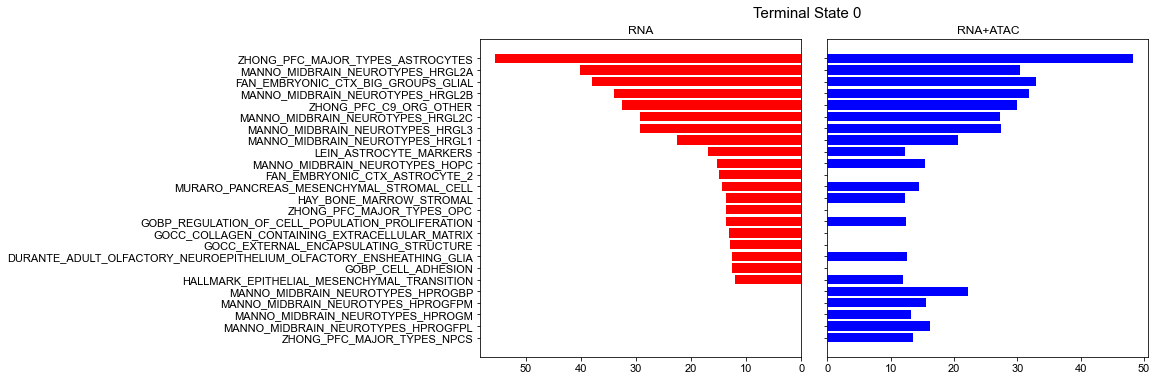

In [495]:
df0 = df_rna_0
df1 = df_result_0

fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
fig.tight_layout()

index = list(df0['Gene Set Name'].values)
column0 = list(df0['neglog_FDR'].values)
gsn_1 = list(df1['Gene Set Name'].values)

missing_gsn = set(df1['Gene Set Name'].values) - set(df0['Gene Set Name'].values) 

for gsn in missing_gsn:
    index.append(gsn)
    column0.append(0)

column1 = []
for gsn in index:
    if gsn in gsn_1:
        column1.append(df_result_0[df_result_0['Gene Set Name'] == gsn]['neglog_FDR'].iloc[0])
    else:
        column1.append(0)

axes[0].barh(index, column0, align='center', color='red', zorder=10)
axes[0].set_title('RNA') #, fontsize=18, pad=15, color=color_red, **hfont)
axes[1].barh(index, column1, align='center', color='blue', zorder=10)
axes[1].set_title('RNA+ATAC') #, fontsize=18, pad=15, color=color_blue, **hfont)

# If you have positive numbers and want to invert the x-axis of the left plot
axes[0].invert_xaxis()

# To show data from highest to lowest
plt.gca().invert_yaxis()

axes[0].set(yticks=index, yticklabels=index)
axes[0].yaxis.tick_left()
axes[0].tick_params(axis='y') #, colors='white') # tick color

#for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
#    label.set(fontsize=13) #, color=font_color, **hfont)
#for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
#    label.set(fontsize=13) #, color=font_color, **hfont)

plt.suptitle('Terminal State 0', y=1.05, fontsize=15)

plt.show()

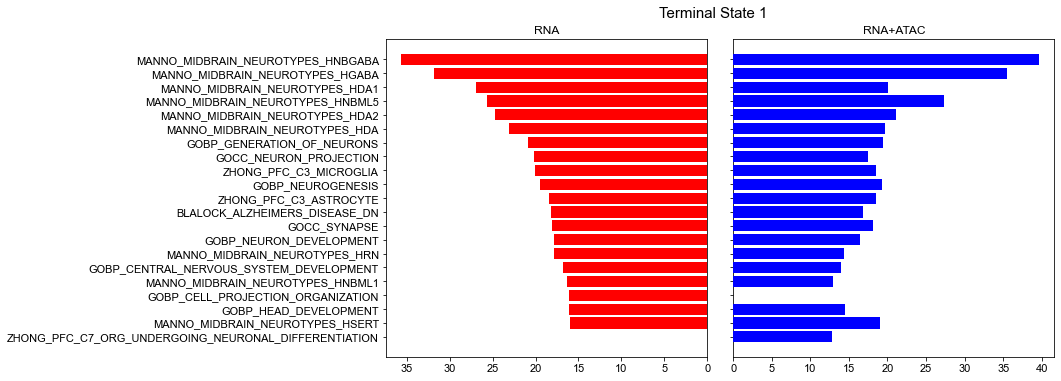

In [483]:
df0 = df_rna_1
df1 = df_result_1

fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)
fig.tight_layout()

index = list(df0['Gene Set Name'].values)
column0 = list(df0['neglog_FDR'].values)
gsn_1 = list(df1['Gene Set Name'].values)

missing_gsn = set(df1['Gene Set Name'].values) - set(df0['Gene Set Name'].values) 

for gsn in missing_gsn:
    index.append(gsn)
    column0.append(0)

column1 = []
for gsn in index:
    if gsn in gsn_1:
        column1.append(df1[df1['Gene Set Name'] == gsn]['neglog_FDR'].iloc[0])
    else:
        column1.append(0)

axes[0].barh(index, column0, align='center', color='red', zorder=10)
axes[0].set_title('RNA') #, fontsize=18, pad=15, color=color_red, **hfont)
axes[1].barh(index, column1, align='center', color='blue', zorder=10)
axes[1].set_title('RNA+ATAC') #, fontsize=18, pad=15, color=color_blue, **hfont)

# If you have positive numbers and want to invert the x-axis of the left plot
axes[0].invert_xaxis()

# To show data from highest to lowest
plt.gca().invert_yaxis()

axes[0].set(yticks=index, yticklabels=index)
axes[0].yaxis.tick_left()
axes[0].tick_params(axis='y') #, colors='white') # tick color

#for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
#    label.set(fontsize=13) #, color=font_color, **hfont)
#for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
#    label.set(fontsize=13) #, color=font_color, **hfont)

plt.suptitle('Terminal State 1', y=1.05, fontsize=15)

plt.show()

<ipython-input-486-34dc17401dcc>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(index)


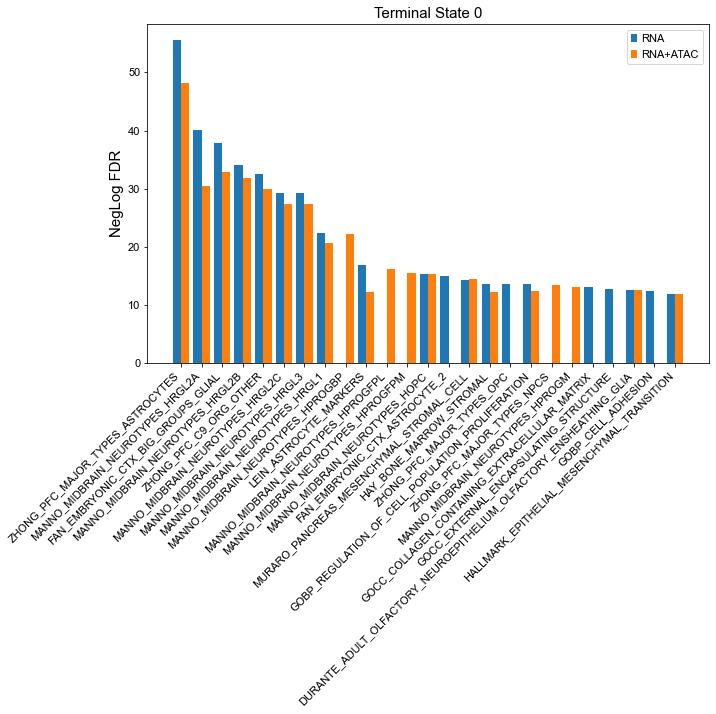

In [486]:
df0 = df_rna_0
df1 = df_result_0

gsn_0 = list(df0['Gene Set Name'].values)
gsn_1 = list(df1['Gene Set Name'].values)

common_gsn = set(gsn_0).intersection(gsn_1)
missing_gsn_in_0 = set(gsn_1) - set(gsn_0) 
missing_gsn_in_1 = set(gsn_0) - set(gsn_1) 

index = []
for gsn in common_gsn:
    index.append(gsn)

for gsn in missing_gsn_in_1:
    index.append(gsn)

for gsn in missing_gsn_in_0:
    index.append(gsn)

column0 = []
for gsn in index:
    if gsn in gsn_0:
        column0.append(df0[df0['Gene Set Name'] == gsn]['neglog_FDR'].iloc[0])
    else:
        column0.append(0)

column1 = []
for gsn in index:
    if gsn in gsn_1:
        column1.append(df1[df1['Gene Set Name'] == gsn]['neglog_FDR'].iloc[0])
    else:
        column1.append(0)

idx_sort = np.argsort(np.max(np.vstack([np.array(column0), np.array(column1)]), axis=0), axis=0)[::-1]
column0 = np.array(column0)[idx_sort]
column1 = np.array(column1)[idx_sort]
index = np.array(index)[idx_sort]

x_axis = np.arange(len(index))

fig, ax = plt.subplots(figsize=(10,6))
# Multi bar Chart
plt.bar(x_axis -0.2, column0, width=0.4, label = 'RNA')
plt.bar(x_axis +0.2, column1, width=0.4, label = 'RNA+ATAC')
ax.set_xticklabels(index)
plt.xticks(x_axis, rotation=45, ha="right")

plt.title('Terminal State 0', fontsize=15)
plt.legend()
plt.ylabel('NegLog FDR', fontsize=15)
plt.show()

<ipython-input-487-de3059573589>:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(index)


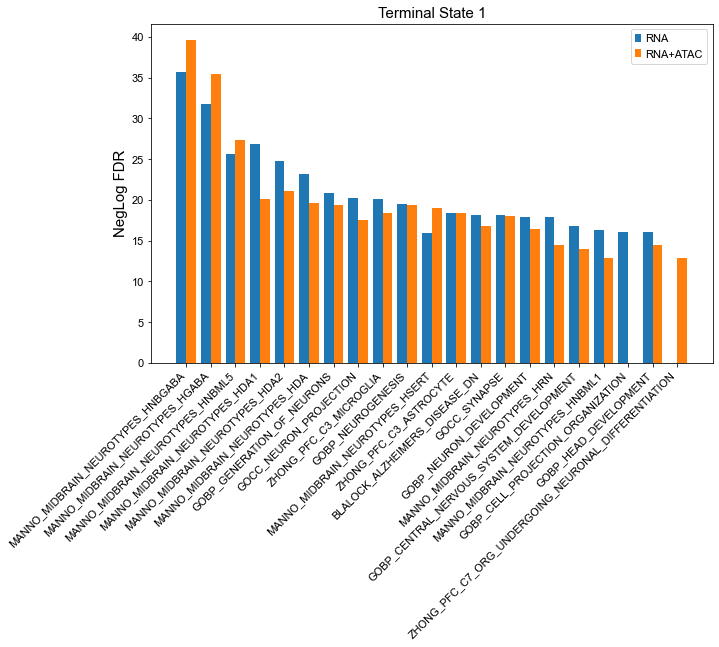

In [487]:
df0 = df_rna_1
df1 = df_result_1

gsn_0 = list(df0['Gene Set Name'].values)
gsn_1 = list(df1['Gene Set Name'].values)

common_gsn = set(gsn_0).intersection(gsn_1)
missing_gsn_in_0 = set(gsn_1) - set(gsn_0) 
missing_gsn_in_1 = set(gsn_0) - set(gsn_1) 

index = []
for gsn in common_gsn:
    index.append(gsn)

for gsn in missing_gsn_in_1:
    index.append(gsn)

for gsn in missing_gsn_in_0:
    index.append(gsn)

column0 = []
for gsn in index:
    if gsn in gsn_0:
        column0.append(df0[df0['Gene Set Name'] == gsn]['neglog_FDR'].iloc[0])
    else:
        column0.append(0)

column1 = []
for gsn in index:
    if gsn in gsn_1:
        column1.append(df1[df1['Gene Set Name'] == gsn]['neglog_FDR'].iloc[0])
    else:
        column1.append(0)

idx_sort = np.argsort(np.max(np.vstack([np.array(column0), np.array(column1)]), axis=0), axis=0)[::-1]
column0 = np.array(column0)[idx_sort]
column1 = np.array(column1)[idx_sort]
index = np.array(index)[idx_sort]

x_axis = np.arange(len(index))

fig, ax = plt.subplots(figsize=(10,6))
# Multi bar Chart
plt.bar(x_axis -0.2, column0, width=0.4, label = 'RNA')
plt.bar(x_axis +0.2, column1, width=0.4, label = 'RNA+ATAC')
ax.set_xticklabels(index)
plt.xticks(x_axis, rotation=45, ha="right")

plt.title('Terminal State 1', fontsize=15)
plt.legend()
plt.ylabel('NegLog FDR', fontsize=15)
plt.show()

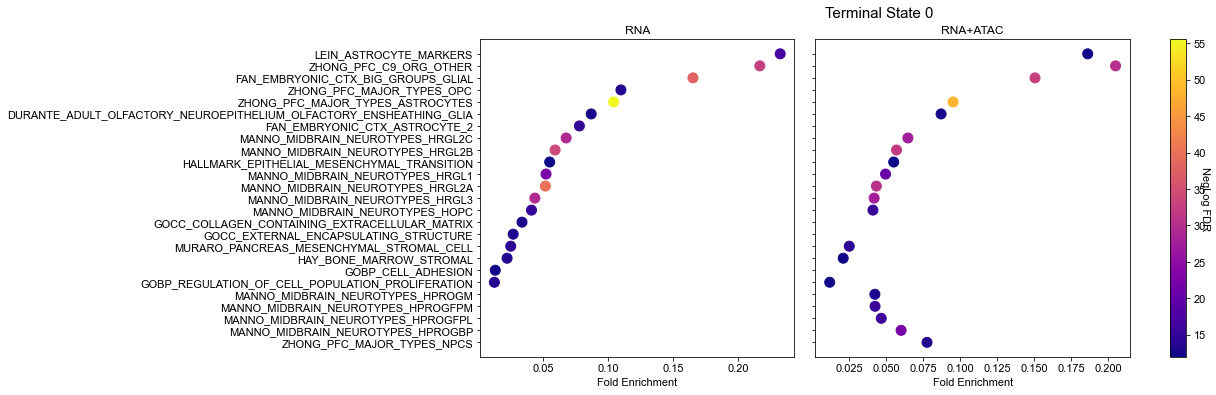

In [575]:
df0 = df_rna_0
df1 = df_result_0

FDR_name = 'neglog_FDR' #'FDR q-value'
kK_name = 'k/K'

gsn_0 = list(df0['Gene Set Name'].values)
gsn_1 = list(df1['Gene Set Name'].values)

common_gsn = set(gsn_0).intersection(gsn_1)
missing_gsn_in_0 = set(gsn_1) - set(gsn_0) 
missing_gsn_in_1 = set(gsn_0) - set(gsn_1) 

index = []
for gsn in common_gsn:
    index.append(gsn)

for gsn in missing_gsn_in_1:
    index.append(gsn)

for gsn in missing_gsn_in_0:
    index.append(gsn)

FDR_data0 = []
kK_data0 = []
for gsn in index:
    if gsn in gsn_0:
        FDR_data0.append(df0[df0['Gene Set Name'] == gsn][FDR_name].iloc[0])
        kK_data0.append(df0[df0['Gene Set Name'] == gsn][kK_name].iloc[0])
    else:
        FDR_data0.append(None)
        kK_data0.append(None)

FDR_data1 = []
kK_data1 = []
for gsn in index:
    if gsn in gsn_1:
        FDR_data1.append(df1[df1['Gene Set Name'] == gsn][FDR_name].iloc[0])
        kK_data1.append(df1[df1['Gene Set Name'] == gsn][kK_name].iloc[0])
    else:
        FDR_data1.append(None)
        kK_data1.append(None)

idx_sort = np.argsort([-1 if x is None else x for x in kK_data0])[::-1]
FDR_data0 = np.array(FDR_data0)[idx_sort]
FDR_data1 = np.array(FDR_data1)[idx_sort]
kK_data0 = np.array(kK_data0)[idx_sort]
kK_data1 = np.array(kK_data1)[idx_sort]
index = np.array(index)[idx_sort]

fig, axes = plt.subplots(figsize=(12,5), ncols=2, sharey=True)
fig.tight_layout()
x_axis = np.arange(len(index))

vmin = min(min([1e10 if x is None else x for x in FDR_data0]), min([1e10 if x is None else x for x in FDR_data1]))
vmax = max(max([-1 if x is None else x for x in FDR_data0]), max([-1 if x is None else x for x in FDR_data1]))

axes[0].scatter(kK_data0, x_axis, s=100, c=FDR_data0, cmap='plasma', vmin=vmin, vmax=vmax)
axes[0].set_title('RNA') #, fontsize=18, pad=15, color=color_red, **hfont)
axp = axes[1].scatter(kK_data1, x_axis, s=100, c=FDR_data1, cmap='plasma', vmin=vmin, vmax=vmax)
axes[1].set_title('RNA+ATAC') #, fontsize=18, pad=15, color=color_blue, **hfont)

# If you have positive numbers and want to invert the x-axis of the left plot
#axes[0].invert_xaxis()

# To show data from highest to lowest
plt.gca().invert_yaxis()

axes[0].set(yticks=x_axis, yticklabels=index)
axes[0].yaxis.tick_left()
axes[0].tick_params(axis='y') #, colors='white') # tick color
axes[0].set_xlabel('Fold Enrichment')
axes[1].set_xlabel('Fold Enrichment')

cb = plt.colorbar(axp,ax=axes,location='right')
cb.set_label('NegLog FDR', rotation=270)

plt.suptitle('Terminal State 0', y=1.05, fontsize=15)

plt.show()

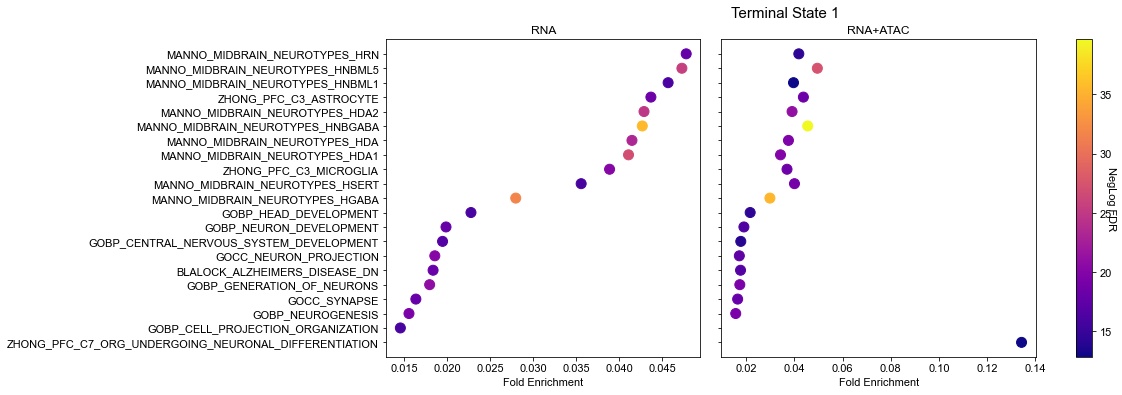

In [576]:
df0 = df_rna_1
df1 = df_result_1

FDR_name = 'neglog_FDR' #'FDR q-value'
kK_name = 'k/K'

gsn_0 = list(df0['Gene Set Name'].values)
gsn_1 = list(df1['Gene Set Name'].values)

common_gsn = set(gsn_0).intersection(gsn_1)
missing_gsn_in_0 = set(gsn_1) - set(gsn_0) 
missing_gsn_in_1 = set(gsn_0) - set(gsn_1) 

index = []
for gsn in common_gsn:
    index.append(gsn)

for gsn in missing_gsn_in_1:
    index.append(gsn)

for gsn in missing_gsn_in_0:
    index.append(gsn)

FDR_data0 = []
kK_data0 = []
for gsn in index:
    if gsn in gsn_0:
        FDR_data0.append(df0[df0['Gene Set Name'] == gsn][FDR_name].iloc[0])
        kK_data0.append(df0[df0['Gene Set Name'] == gsn][kK_name].iloc[0])
    else:
        FDR_data0.append(None)
        kK_data0.append(None)

FDR_data1 = []
kK_data1 = []
for gsn in index:
    if gsn in gsn_1:
        FDR_data1.append(df1[df1['Gene Set Name'] == gsn][FDR_name].iloc[0])
        kK_data1.append(df1[df1['Gene Set Name'] == gsn][kK_name].iloc[0])
    else:
        FDR_data1.append(None)
        kK_data1.append(None)

idx_sort = np.argsort([-1 if x is None else x for x in kK_data0])[::-1]
FDR_data0 = np.array(FDR_data0)[idx_sort]
FDR_data1 = np.array(FDR_data1)[idx_sort]
kK_data0 = np.array(kK_data0)[idx_sort]
kK_data1 = np.array(kK_data1)[idx_sort]
index = np.array(index)[idx_sort]

fig, axes = plt.subplots(figsize=(12,5), ncols=2, sharey=True)
fig.tight_layout()
x_axis = np.arange(len(index))

vmin = min(min([1e10 if x is None else x for x in FDR_data0]), min([1e10 if x is None else x for x in FDR_data1]))
vmax = max(max([-1 if x is None else x for x in FDR_data0]), max([-1 if x is None else x for x in FDR_data1]))

axes[0].scatter(kK_data0, x_axis, s=100, c=FDR_data0, cmap='plasma', vmin=vmin, vmax=vmax)
axes[0].set_title('RNA') #, fontsize=18, pad=15, color=color_red, **hfont)
axp = axes[1].scatter(kK_data1, x_axis, s=100, c=FDR_data1, cmap='plasma', vmin=vmin, vmax=vmax)
axes[1].set_title('RNA+ATAC') #, fontsize=18, pad=15, color=color_blue, **hfont)

# If you have positive numbers and want to invert the x-axis of the left plot
#axes[0].invert_xaxis()

# To show data from highest to lowest
plt.gca().invert_yaxis()

axes[0].set(yticks=x_axis, yticklabels=index)
axes[0].yaxis.tick_left()
axes[0].tick_params(axis='y') #, colors='white') # tick color
axes[0].set_xlabel('Fold Enrichment')
axes[1].set_xlabel('Fold Enrichment')

cb = plt.colorbar(axp,ax=axes,location='right')
cb.set_label('NegLog FDR', rotation=270)

plt.suptitle('Terminal State 1', y=1.05, fontsize=15)

plt.show()

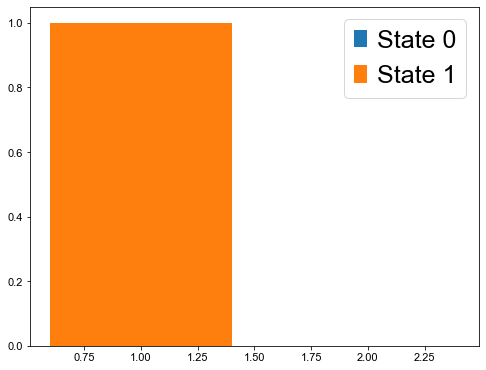

In [548]:
plt.figure(figsize=(8,6))
plt.bar([1,2], [1,0], label='State 0')
plt.bar([1,2], [1,0], label='State 1')
plt.legend(fontsize=25)
plt.show()

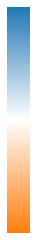

In [563]:
from matplotlib.colors import LinearSegmentedColormap

colors = [u'#1f77b4', u'#ffffff', u'#ff7f0e'] # first color is black, last is red
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=200)
mat = np.indices((100,1000))[1]
plt.imshow(mat.T, cmap=cm)
plt.axis('off')
plt.show()

In [165]:
print('RNA only, Terminal State 0', *rna_corr_0[:10].index, sep=', ', end='...\n')
print('RNA+ATAC, Terminal State 0', *result_corr_0[:10].index, sep=', ', end='...\n')
print('RNA only, Terminal State 1', *rna_corr_1[:10].index, sep=', ', end='...\n')
print('RNA+ATAC, Terminal State 1', *result_corr_1[:10].index, sep=', ', end='...\n')

RNA only, Terminal State 0, Mfge8, Tnc, Slc1a3, Atp1a2, Sparc, Ttyh1, Ccdc80, Pdpn, Plpp3, Mlc1...
RNA+ATAC, Terminal State 0, Mfge8, Tnc, Slc1a3, Atp1a2, Sparc, Notch1, Ccdc80, Pdpn, Slco1c1, Plpp3...
RNA only, Terminal State 1, Gria2, Basp1, Igfbpl1, Tuba1a, Celf2, Rtn1, Tmsb10, Ahi1, Ptprd, Map1b...
RNA+ATAC, Terminal State 1, Gria2, Rtn1, Tuba1a, Celf2, Basp1, Ahi1, Map1b, Ptprd, Tmsb10, Nrxn1...


In [207]:
for n in [10, 15, 25, 35, 50, 100, 200, 250, 300, 400]:
    result_corr_0 = adata_result.varm['terminal_lineage_drivers']["0_corr"].sort_values(ascending=False).iloc[:n]
    result_corr_1 = adata_result.varm['terminal_lineage_drivers']["1_corr"].sort_values(ascending=False).iloc[:n]
    rna_corr_0 = adata_rna.varm['terminal_lineage_drivers']["0_corr"].sort_values(ascending=False).iloc[:n]
    rna_corr_1 = adata_rna.varm['terminal_lineage_drivers']["1_corr"].sort_values(ascending=False).iloc[:n]

    genes_rna = list(rna_corr_0.index)+list(rna_corr_1.index)
    genes_result = list(result_corr_0.index)+list(result_corr_1.index)

    print(str(len(genes_rna)), f'prop {len(set(genes_rna).intersection(genes_result)) / len(genes_rna):.2f}')

20 prop 0.85
30 prop 0.83
50 prop 0.80
70 prop 0.83
100 prop 0.85
200 prop 0.80
400 prop 0.82
500 prop 0.86
600 prop 0.89
800 prop 0.92


In [208]:
for n in [10, 15, 25, 35, 50, 100, 200, 250, 300, 400]:
    result_corr_0 = adata_result.varm['terminal_lineage_drivers']["0_corr"].sort_values(ascending=False).iloc[:n]
    result_corr_1 = adata_result.varm['terminal_lineage_drivers']["1_corr"].sort_values(ascending=False).iloc[:n]
    rna_corr_0 = adata_rna.varm['terminal_lineage_drivers']["0_corr"].sort_values(ascending=False).iloc[:n]
    rna_corr_1 = adata_rna.varm['terminal_lineage_drivers']["1_corr"].sort_values(ascending=False).iloc[:n]

    genes_rna = list(rna_corr_0.index) #+list(rna_corr_1.index)
    genes_result = list(result_corr_0.index) #+list(result_corr_1.index)

    print(str(len(genes_rna)), f'prop {len(set(genes_rna).intersection(genes_result)) / len(genes_rna):.2f}')

10 prop 0.80
15 prop 0.80
25 prop 0.76
35 prop 0.77
50 prop 0.82
100 prop 0.71
200 prop 0.73
250 prop 0.80
300 prop 0.86
400 prop 0.91


In [209]:
for n in [10, 15, 25, 35, 50, 100, 200, 250, 300, 400]:
    result_corr_0 = adata_result.varm['terminal_lineage_drivers']["0_corr"].sort_values(ascending=False).iloc[:n]
    result_corr_1 = adata_result.varm['terminal_lineage_drivers']["1_corr"].sort_values(ascending=False).iloc[:n]
    rna_corr_0 = adata_rna.varm['terminal_lineage_drivers']["0_corr"].sort_values(ascending=False).iloc[:n]
    rna_corr_1 = adata_rna.varm['terminal_lineage_drivers']["1_corr"].sort_values(ascending=False).iloc[:n]

    genes_rna = list(rna_corr_1.index)
    genes_result = list(result_corr_1.index)

    print(str(len(genes_rna)), f'prop {len(set(genes_rna).intersection(genes_result)) / len(genes_rna):.2f}')

10 prop 0.90
15 prop 0.87
25 prop 0.84
35 prop 0.89
50 prop 0.88
100 prop 0.89
200 prop 0.92
250 prop 0.92
300 prop 0.92
400 prop 0.88
